In [1]:
import camb
from camb import model, initialpower
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.optimize import minimize_scalar

In [2]:
# 2018 standard Planck cosmology
# Scalar spectral index
ns = 0.9649
# Scalar amplitude
As = np.exp(3.044)/1e10
# Optical depth
tau = 0.0544
# Baryon density
Ombh2 = 0.02237
# Photons density
Omgh2 = 2.4728018939804827e-05
# Hubble cte
h = 0.6736
H0 = 100*h
# Num. effective relativistic particles
Neff_values = np.array([0.0, 3.04, 8.0])
# Epoch of equality
# zeq = 3195.03
zeq = 33402
# CDM density
# Omch2 = (1 + zeq)*Omgh2*(1 + (7/8)*(4/11)**(4/3)*Neff_values) - Ombh2
Omch2 =  0.1200

In [12]:
# Function to compute CMB power spectrum for given Neff value
def get_cmb_spectrum(Neff = 3.044, Omch2 = 0.1200, Mnu = 0.06, H0=67.36):
    pars = camb.CAMBparams()
    pars.InitPower.set_params(ns=ns, As=As)
    pars.set_cosmology(H0=H0, ombh2=Ombh2, omch2=Omch2, omk=0, tau=tau, standard_neutrino_neff=Neff, num_massive_neutrinos=1, neutrino_hierarchy='normal', mnu=Mnu, nnu=Neff)
    pars.set_dark_energy() # To ensure dark energy is set to default values
    pars.set_for_lmax(2500, lens_potential_accuracy=0)
    results = camb.get_results(pars)
    powers = results.get_cmb_power_spectra(pars, CMB_unit='muK')#, spectra=0)
    cmb = powers['total']
    tt = cmb[:, 0]  # TT spectrum
    ee = cmb[:, 1]  # EE spectrum
    bb = cmb[:, 2]  # BB spectrum
    l_arr = np.arange(tt.shape[0]) 
    return tt, l_arr

# Function to compute matter power spectrum for given Neff value
def get_matter_power_spectrum(Neff = 3.044, Omch2 = 0.1200, Mnu = 0.0, z = 0):
    pars = camb.CAMBparams()
    pars.InitPower.set_params(ns=ns, As=As)
    pars.set_cosmology(H0=H0, ombh2=Ombh2, omch2=Omch2, omk=0, tau=tau, standard_neutrino_neff=Neff, num_massive_neutrinos=1, neutrino_hierarchy='normal', mnu=Mnu, nnu=Neff)
    pars.set_matter_power(redshifts=[z], kmax=3.0)
    results = camb.get_results(pars)
    kh, z, pk = results.get_matter_power_spectrum(minkh=1e-5, maxkh=3.0, npoints=2000)
    return kh, pk[0]

## Figure (2.4)

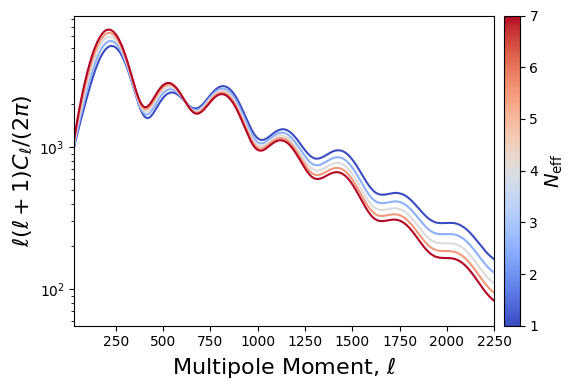

In [ ]:
# Function to compute the angular size of the sound horizon (thetastar)
def get_thetastar(Neff, H0=67.36, Omch2=0.1200, Mnu=0.0):
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=H0, ombh2=Ombh2, omch2=Omch2, omk=0, tau=tau, standard_neutrino_neff=Neff, num_massive_neutrinos=1, neutrino_hierarchy='normal', mnu=Mnu, nnu=Neff)
    results = camb.get_results(pars)
    return results.get_derived_params()['thetastar'] 

Neff_values = np.linspace(1, 7, 5)  # Example Neff values
thetastar0 = get_thetastar(3.044)#, Mnu=0.06)

cmap = plt.get_cmap('coolwarm')  # Blue to red colormap
norm = mpl.colors.Normalize(vmin=Neff_values.min(), vmax=Neff_values.max())
plt.figure(figsize=(6, 4))
# for i, j in zip(Neff_values, Omch2):
    # tt, ell = get_cmb_spectrum(Neff=i, Omch2=j, Mnu=0.0)

for i in Neff_values:
    Omch2 = (1 + zeq)*Omgh2*(1 + (7/8)*(4/11)**(4/3)*i) - Ombh2
    thetastar = get_thetastar(i)#, Mnu=0.06)#,Omch2=Omch2)
    tt, ell = get_cmb_spectrum(Neff=i)#, Mnu=0.06)#,Omch2=Omch2)
    color = cmap(norm(i))
    plt.plot((thetastar/thetastar0)*ell, tt, label=f'Neff={i:.1f}', color=color)
plt.xlabel('Multipole Moment, $\ell$', fontsize=16)
plt.ylabel('$\ell(\ell+1)C_\ell / (2\pi)$', fontsize=16)
plt.xlim(30, 2250)
plt.yscale('log')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Dummy array for the colorbar
cbar = plt.colorbar(sm, ax=plt.gca(), pad=0.02)  # Position the colorbar
cbar.set_label(r'$N_{\rm eff}$', fontsize=14)
plt.tight_layout()
plt.show()

c:\Users\hugor\miniconda3\envs\cambamb\lib\site-packages\scipy\optimize\_minimize.py:783: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


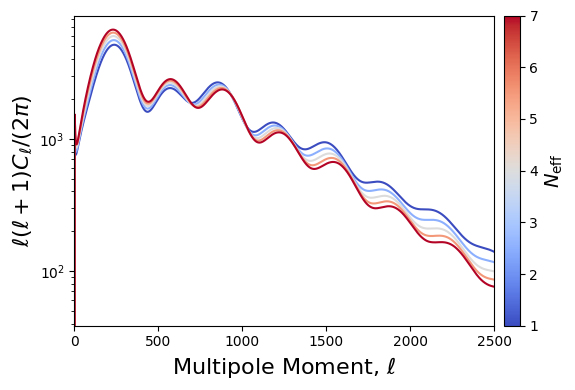

In [8]:
# Function to compute the angular size of the sound horizon (thetastar)
def get_thetastar(H0, Neff, Omch2=0.1200, Mnu=0.0):
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=H0, ombh2=Ombh2, omch2=Omch2, omk=0, tau=tau, standard_neutrino_neff=Neff, num_massive_neutrinos=1, neutrino_hierarchy='normal', mnu=Mnu, nnu=Neff)
    results = camb.get_results(pars)
    return results.get_derived_params()['thetastar'] 

# Function to find H0 such that thetastar equals the target value
def adjust_H0_to_thetastar(Neff, Omch2=0.1200, target_thetastar = 1.04110, tol=1e-5):
    def objective(H0):
        thetastar = get_thetastar(H0, Neff, Omch2=Omch2)
        return np.abs(thetastar - target_thetastar)
    result = minimize_scalar(objective, bounds=(50, 100), method='bounded', tol=tol)
    if result.success:
        return result.x  # Return the optimized H0
    else:
        raise ValueError("H0 adjustment failed to converge.")

plt.figure(figsize=(6, 4))
thetastar0 = get_thetastar(67.36, 3.044)

for i in range(Neff_values.size):
    H0 = adjust_H0_to_thetastar(Neff_values[i])
    thetastar = get_thetastar(H0, i)
    tt, ell = get_cmb_spectrum(Neff=Neff_values[i], H0=H0)
    color = cmap(norm(Neff_values[i]))
    plt.plot((thetastar/thetastar0)*ell, tt, label=f'Neff={Neff_values[i]:.1f}', color=color)
plt.xlabel('Multipole Moment, $\ell$', fontsize=16)
plt.ylabel('$\ell(\ell+1)C_\ell / (2\pi)$', fontsize=16)
plt.xlim(0, 2500)
plt.yscale('log')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca(), pad=0.02)
cbar.set_label(r'$N_{\rm eff}$', fontsize=14)
plt.tight_layout()
plt.show()

## Figure (2.5)

## Figure (2.6)

C:\Users\hugor\AppData\Local\Temp\ipykernel_13984\511342928.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


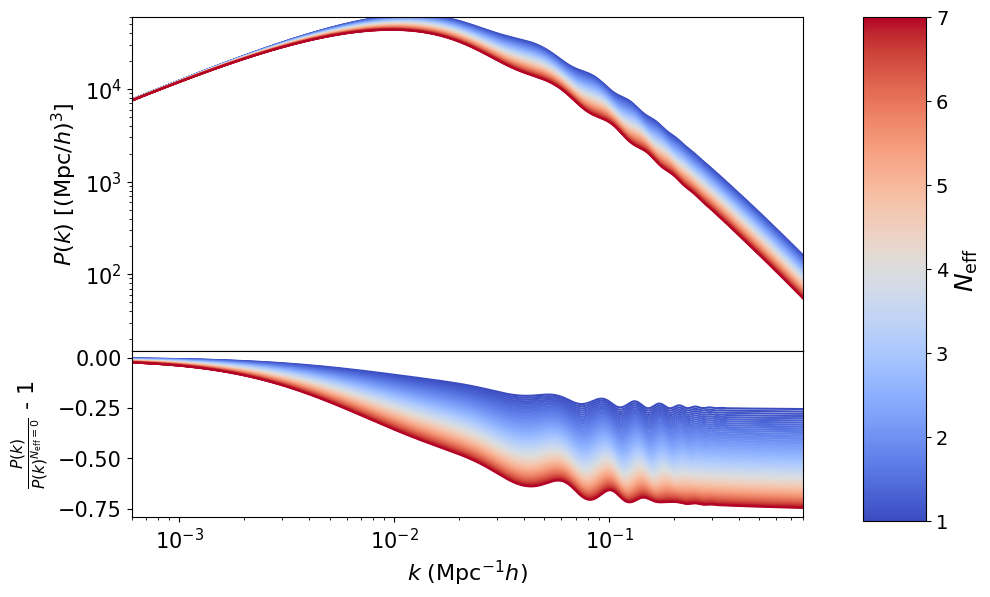

In [6]:
Neff_values = np.linspace(1, 7, 100)  # Example Neff values
cmap = plt.get_cmap('coolwarm')  # Blue to Red colormap
norm = mpl.colors.Normalize(vmin=Neff_values.min(), vmax=Neff_values.max())

fig, axs = plt.subplots(2, 1, figsize=(9, 6), sharex=True, gridspec_kw={'height_ratios': [2, 1], 'hspace': 0})
kh, pk0 = get_matter_power_spectrum(0.0)
for Neff in Neff_values:
    kh, pk = get_matter_power_spectrum(Neff)
    color = cmap(norm(Neff))
    axs[0].loglog(kh, pk, color=color)
    axs[1].plot(kh, (pk - pk0) / pk0, color=color)
axs[0].set_ylabel('$P(k)$ [(Mpc/$h$)$^3]$', fontsize=16)
axs[0].set_xlim(1e-3, 1.0)
axs[0].set_ylim(15, 60000)
axs[0].tick_params(axis='both', which='major', labelsize=15)  # Increase font size of tick labels
axs[1].set_ylabel(r'$\frac{P(k)}{P(k)^{N_{\rm eff}=0}}$ - 1', fontsize=16)
axs[1].set_xlabel('$k$ (Mpc$^{-1}h$)', fontsize=16)
axs[1].set_xlim(0.6e-3, 0.8)
axs[1].set_xscale('log')
axs[1].tick_params(axis='both', which='major', labelsize=15)  # Increase font size of tick labels
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar_ax = fig.add_axes([0.95, 0.135, 0.07, 0.84])  # [left, bottom, width, height]
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label(r'$N_{\rm eff}$', fontsize=18)
cbar.ax.tick_params(labelsize=14)  # Increase font size of colorbar tick labels
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.savefig('Fig_26.pdf', bbox_inches='tight')
plt.show()

In [7]:
# plt.savefig('Fig_26.pdf', bbox_inches='tight')

## Figure (2.8)

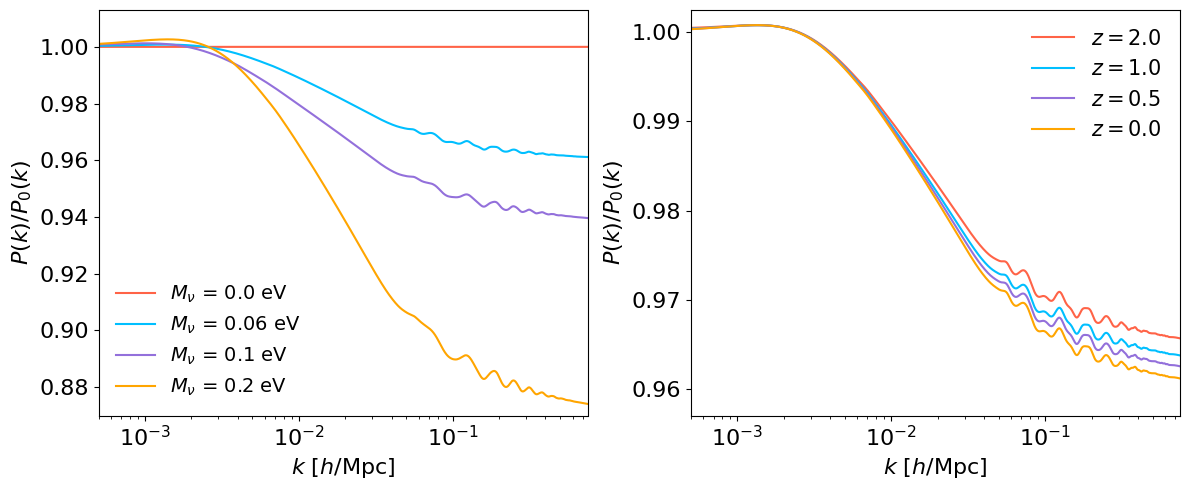

In [36]:
# Values of Neff to plot
# Mnu_values = np.array([0.01, 0.05, 0.15])
Mnu_values = np.array([0.0, 0.06, 0.10, 0.20])
OmMh2 = Omch2 + Ombh2

z_values = [2.0, 1.0, 0.5, 0.0]
# blue_colors = plt.cm.Blues(np.linspace(0.6, 1, 3))  # 4 blue shades, from darker to lighter
# red_colors = plt.cm.Reds(np.linspace(0.6, 1, 3))    # 4 red shades, from darker to lighter
blue_colors = ['tomato', 'deepskyblue', 'mediumpurple', 'orange']
red_colors = ['tomato', 'deepskyblue', 'mediumpurple', 'orange']

# Create a figure with 1 row and 2 columns for side-by-side plots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
kh0, pk0 = get_matter_power_spectrum(Mnu=0.0)
for i in range(4):
    Omch2_fid = OmMh2 - Ombh2 - (Mnu_values[i]/94.14)
    kh, pk = get_matter_power_spectrum(Mnu=Mnu_values[i], Omch2=Omch2_fid)
    axs[0].plot(kh, pk / pk0, label=f'$M_\\nu$ = {Mnu_values[i]} eV', color=blue_colors[i])
axs[0].set_xlabel('$k$ [$h$/Mpc]', fontsize=16)
axs[0].set_ylabel('$P(k)/P_0(k)$', fontsize=16)
axs[0].set_xscale('log')
axs[0].set_xlim(0.5e-3, 0.75)
axs[0].set_ylim(0.87, 1.013)
axs[0].legend(loc='best', fontsize=14, frameon=False)
axs[0].tick_params(axis='both', which='major', labelsize=16)  # Increase font size of tick labels
for i in range(4):
    Omch2_fid = OmMh2 - Ombh2 - (0.06/94.14)
    kh0, pk0 = get_matter_power_spectrum(z=z_values[i])
    kh, pk = get_matter_power_spectrum(z=z_values[i], Mnu=0.06, Omch2=Omch2_fid)
    axs[1].plot(kh, pk / pk0, label=f'$z = {z_values[i]}$', color=red_colors[i])
axs[1].set_xlabel('$k$ [$h$/Mpc]', fontsize=16)
axs[1].set_ylabel('$P(k)/P_0(k)$', fontsize=16)
axs[1].set_xscale('log')
axs[1].set_xlim(0.5e-3, 0.75)
axs[1].set_ylim(0.957, 1.0025)
axs[1].legend(loc='best', fontsize=15, frameon=False)
axs[1].tick_params(axis='both', which='major', labelsize=16)  # Increase font size of tick labels
plt.tight_layout()
plt.savefig('Fig_28.pdf', bbox_inches='tight')
plt.show()